In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import ruptures as rpt
from datetime import datetime
import os
from fredapi import Fred
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Set API key for FRED
fred_api_key = "b854a334011411eddeccad0687b69290"  # Replace with your FRED API key
fred = Fred(api_key=fred_api_key)

# Paths for data files
data_dir = r"C:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Change point analysis\data\processed"
brent_data_path = os.path.join(data_dir, "cleaned_brent_oil_prices.csv")
events_data_path = os.path.join(data_dir, "cleaned_events_data.csv")


In [11]:
# Function to download historical Brent oil prices
def download_data():
    ticker = "BZ=F"
    start_date = "1987-05-20"
    end_date = "2022-09-30"
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[["Close"]].rename(columns={"Close": "Price"})
    data.index.name = "Date"
    return data

# Load data
def load_data():
    if os.path.exists(brent_data_path):
        data = pd.read_csv(brent_data_path, index_col="Date", parse_dates=True)
    else:
        data = download_data()
        data.to_csv(brent_data_path)
    return data

brent_data = load_data()
brent_data.head()


,Price
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953


In [12]:
# Fetch economic indicators
def fetch_economic_data():
    gdp_growth = fred.get_series("GDP")
    inflation = fred.get_series("CPIAUCSL")
    unemployment = fred.get_series("UNRATE")
    usd_index = fred.get_series("DTWEXBGS")
    economic_data = pd.DataFrame({
        "GDP_Growth": gdp_growth,
        "Inflation": inflation,
        "Unemployment": unemployment,
        "USD_Index": usd_index,
    })
    economic_data.index = pd.to_datetime(economic_data.index)
    economic_data = economic_data.resample("M").mean()
    return economic_data

economic_data = fetch_economic_data()
economic_data.head()


C:\Users\hayyu.ragea\AppData\Local\Temp\ipykernel_23404\2672160130.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  economic_data = economic_data.resample("M").mean()


,GDP_Growth,Inflation,Unemployment,USD_Index
1946-01-31,NaN,NaN,NaN,NaN
1946-02-28,NaN,NaN,NaN,NaN
1946-03-31,NaN,NaN,NaN,NaN
1946-04-30,NaN,NaN,NaN,NaN
1946-05-31,NaN,NaN,NaN,NaN


In [13]:
# Merge oil and economic data
def merge_data_with_oil_prices(oil_data, economic_data):
    merged_data = oil_data.join(economic_data, how="inner")
    merged_data.dropna(inplace=True)
    return merged_data

merged_data = merge_data_with_oil_prices(brent_data, economic_data)
merged_data.head()


,Price,GDP_Growth,Inflation,Unemployment,USD_Index
2007-07-31,76.395000,14564.117,207.603,4.7,93.205914
2007-10-31,82.456957,14715.058,209.190,4.7,90.400178
2008-01-31,92.112381,14706.538,212.174,5.0,89.397117
2008-04-30,110.441817,14865.701,213.942,5.0,86.547536
2008-07-31,134.099545,14898.999,219.016,5.8,86.453757


            Price    GDP_Growth   Inflation  Unemployment   USD_Index
count   61.000000     61.000000   61.000000     61.000000   61.000000
mean    78.240965  18441.071951  239.065279      6.359016  103.125593
std     26.082479   3246.251355   20.199635      2.347863   11.345616
min     26.631429  14381.236000  207.603000      3.500000   86.317805
25%     56.621818  15557.539000  224.093000      4.500000   92.440300
50%     74.795239  18063.529000  237.430000      5.700000  103.760740
75%    104.705000  20798.730000  252.561000      8.200000  114.075755
max    134.099545  26272.011000  294.977000     14.800000  123.289350


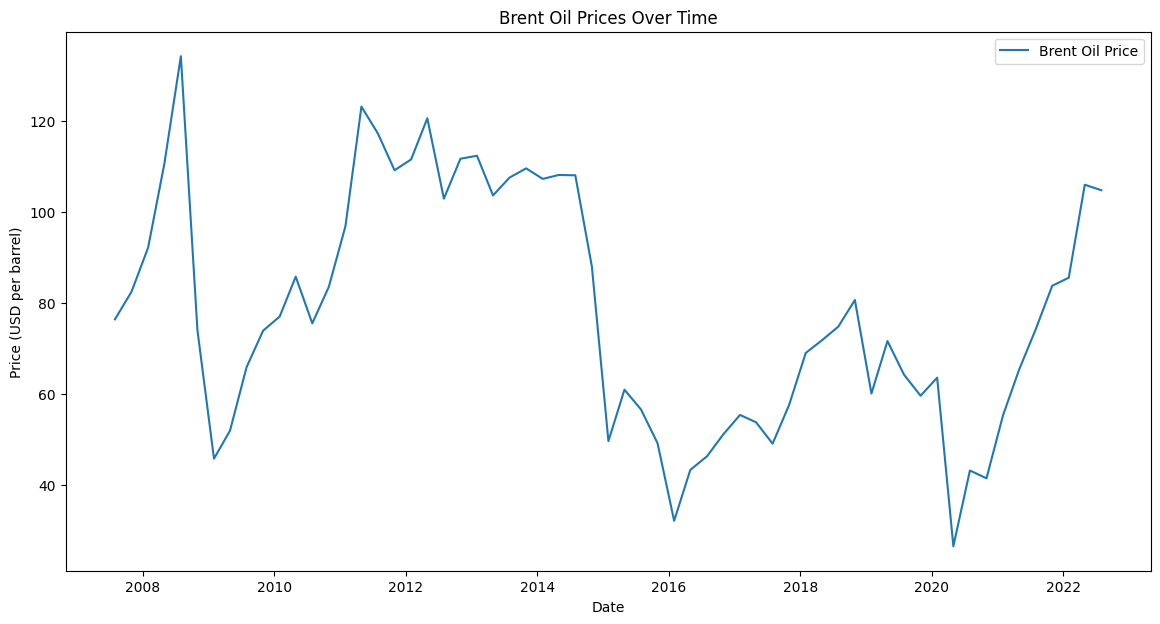

ADF Statistic: -2.1761686625497942
p-value: 0.2150082585602031
Data is non-stationary, further differencing or transformation might be required.


In [14]:
# Perform exploratory data analysis
def eda(data):
    print(data.describe())
    plt.figure(figsize=(14, 7))
    plt.plot(data["Price"], label="Brent Oil Price")
    plt.title("Brent Oil Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.show()

    # Check stationarity
    result = adfuller(data["Price"])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary, further differencing or transformation might be required.")

eda(merged_data)


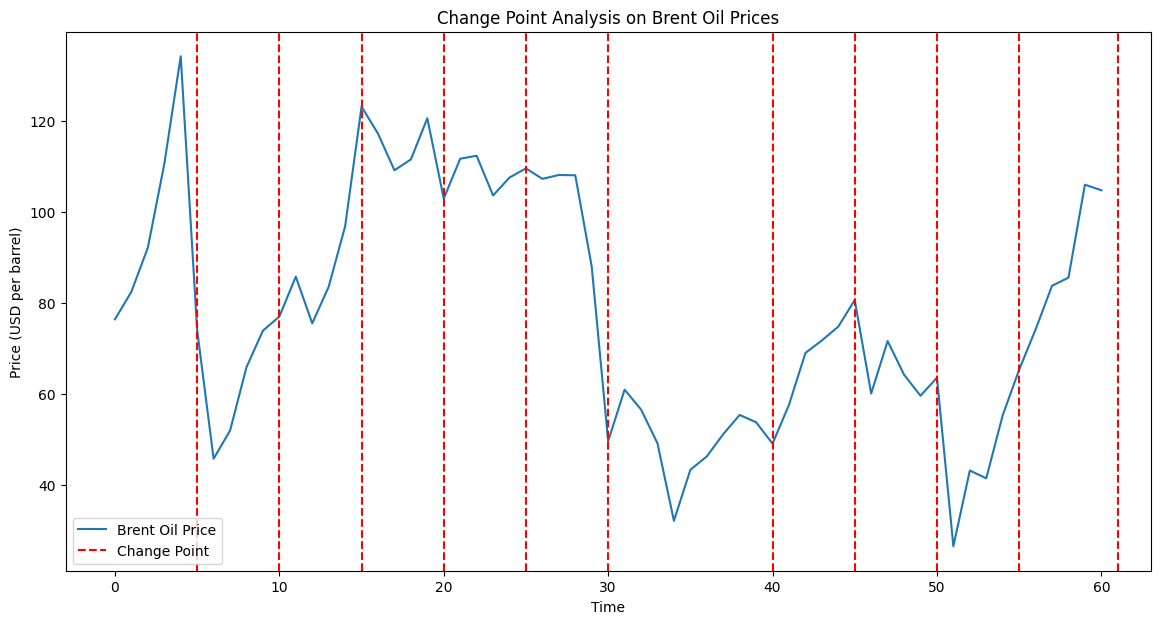

In [15]:
# Change Point Detection
def change_point_detection(data):
    series = data["Price"].values
    algo = rpt.Binseg(model="l2").fit(series)
    change_points = algo.predict(n_bkps=10)
    plt.figure(figsize=(14, 7))
    plt.plot(series, label="Brent Oil Price")
    for cp in change_points:
        plt.axvline(cp, color="r", linestyle="--", label="Change Point" if cp == change_points[0] else "")
    plt.title("Change Point Analysis on Brent Oil Prices")
    plt.xlabel("Time")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.show()
    return change_points

change_points = change_point_detection(merged_data)


c:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Change point analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Change point analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Change point analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   61
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -246.142
Date:                Thu, 07 Nov 2024   AIC                            498.285
Time:                        09:56:16   BIC                            504.568
Sample:                    07-31-2007   HQIC                           500.742
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8566      0.117      7.310      0.000       0.627       1.086
ma.L1         -0.9997      8.568     -0.117      0.907     -17.793      15.794
sigma2       208.1543   1762.914      0.118      0.9

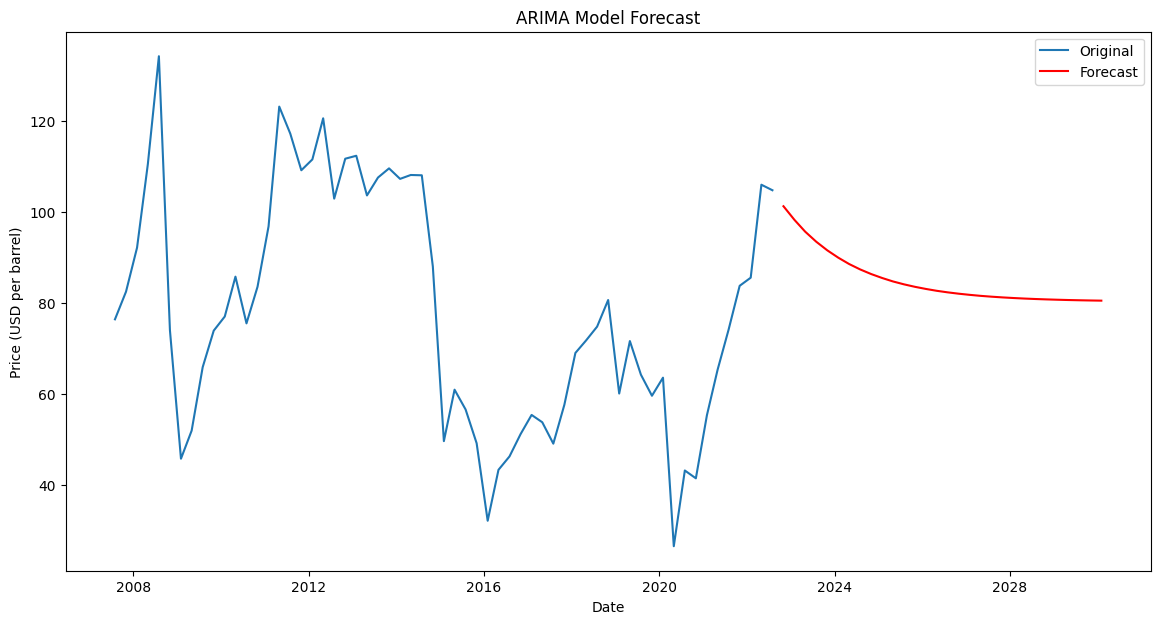

In [16]:
# Time series modeling using ARIMA
def time_series_modeling(data, order=(1, 1, 1)):
    model = ARIMA(data["Price"], order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    forecast = fitted_model.forecast(steps=30)
    plt.figure(figsize=(14, 7))
    plt.plot(data["Price"], label="Original")
    plt.plot(forecast, label="Forecast", color="red")
    plt.title("ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.show()
    return fitted_model

fitted_model = time_series_modeling(merged_data)


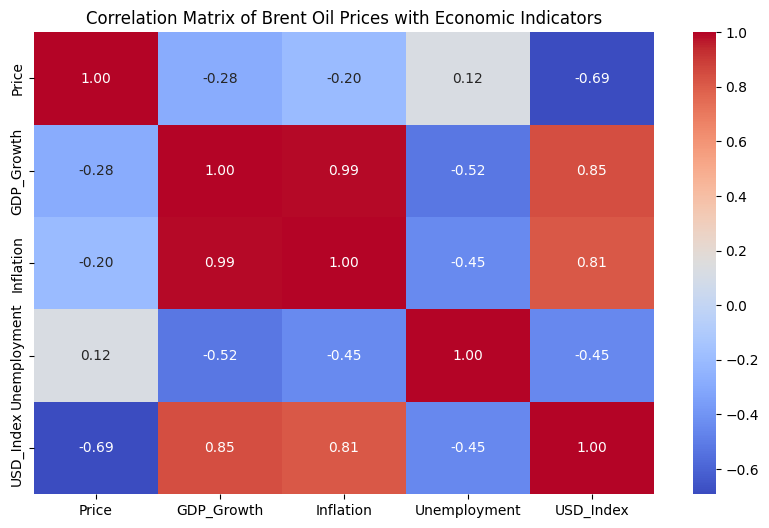

In [17]:
# Analyze economic factors
def analyze_economic_factors(merged_data):
    correlation_matrix = merged_data.corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Brent Oil Prices with Economic Indicators")
    plt.show()

analyze_economic_factors(merged_data)


c:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Change point analysis\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2687
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1906 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1322 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0991 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0591 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0543 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0611
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0690 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0512 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0519 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0532
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0533 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0507 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0566 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0507
Epoch 16/100
2/2 ━

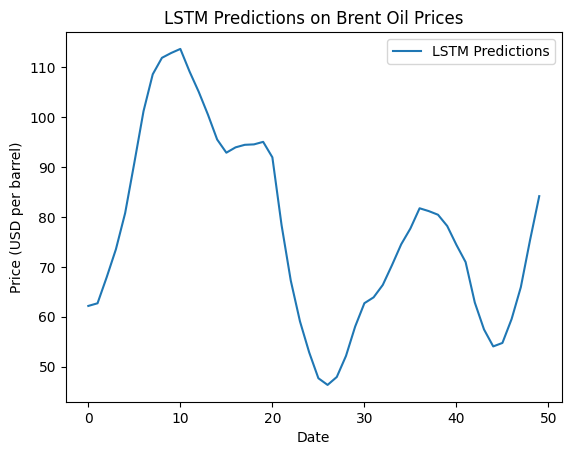

In [18]:
# LSTM Forecasting
def lstm_forecasting(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data["Price"].values.reshape(-1, 1))

    def create_dataset(dataset, time_step=1):
        X, Y = [], []
        for i in range(len(dataset) - time_step - 1):
            X.append(dataset[i : (i + time_step), 0])
            Y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 10
    X, Y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(X, Y, epochs=100, batch_size=32)

    predictions = model.predict(X)
    plt.plot(scaler.inverse_transform(predictions), label="LSTM Predictions")
    plt.title("LSTM Predictions on Brent Oil Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.show()

lstm_forecasting(merged_data)
